In [ ]:
!pip install nbstripout
!nbstripout KaushikiPriyaTiwary_AI_project_submission.ipynb

# Employee Sentiment Analysis

##Mounted drive to upload the CSV file

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
file_path = '/content/drive/MyDrive/Springer/test(in).csv'
df = pd.read_csv(file_path)

# Preview the data
df.head()

,Subject,body,date,from
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,5/10/2010,sally.beck@enron.com
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",7/29/2010,eric.bass@enron.com
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",7/25/2011,sally.beck@enron.com
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,3/25/2010,johnny.palmer@enron.com
4,Bet,Since you never gave me the $20 for the last t...,5/21/2011,lydia.delgado@enron.com


In [ ]:
df.dtypes

,0
Subject,object
body,object
date,object
from,object


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.4 MB/s eta 0:00:00


##1.EDA

# Changing date datatype to datetime

In [ ]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')

In [ ]:
df.dtypes

,0
Subject,object
body,object
date,datetime64[ns]
from,object


In [ ]:
df.isna().sum()

,0
Subject,0
body,0
date,0
from,0


In [ ]:
df.shape

(2191, 4)

In [ ]:
df.nunique()

,0
Subject,1251
body,1539
date,690
from,10


#Top mail senders

In [ ]:
df_mail_senders = df['from'].value_counts().head(10)
df_mail_senders

,count
from,
lydia.delgado@enron.com,284
john.arnold@enron.com,256
sally.beck@enron.com,227
patti.thompson@enron.com,225
bobette.riner@ipgdirect.com,217
don.baughman@enron.com,213
johnny.palmer@enron.com,213
eric.bass@enron.com,210
kayne.coulter@enron.com,174


#Seasonality of emails by years and months

In [ ]:
df_year = df['date'].dt.year
df_month = df['date'].dt.month
df_year_month = pd.crosstab(df_year, df_month)
df_year_month

date,1,2,3,4,5,6,7,8,9,10,11,12
date,,,,,,,,,,,,
2010,91,91,91,92,91,92,91,91,91,91,91,91
2011,91,91,92,92,92,91,91,91,91,91,92,92


As per above result, no exceptional difference has been seen.

#Heatmap for seasonality

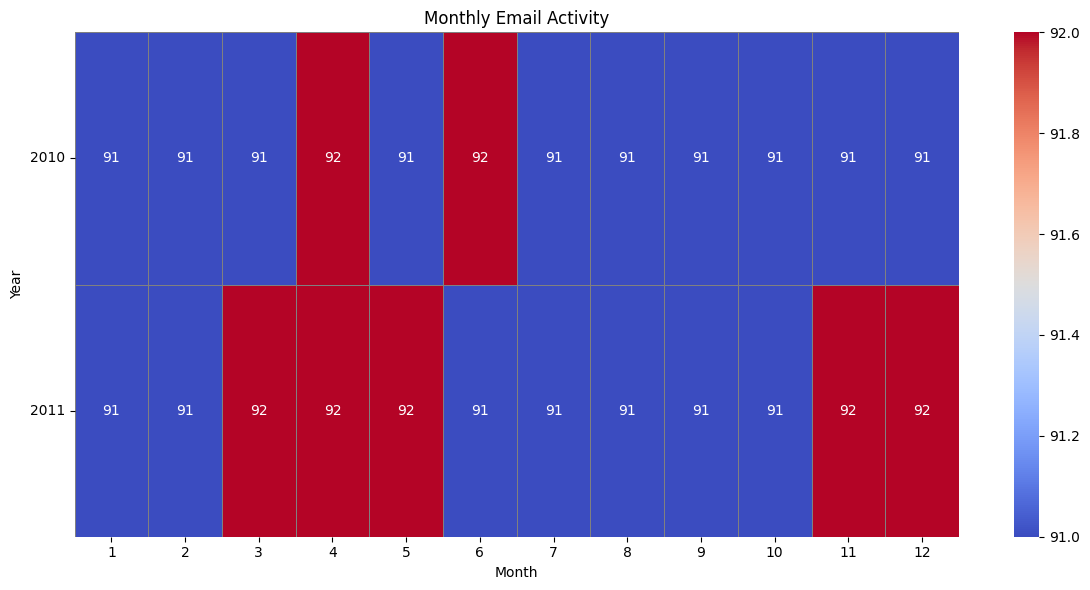

In [ ]:
plt.figure(figsize=(12, 6))
sns.heatmap(df_year_month, annot=True, fmt='d', cmap='coolwarm', linewidths=0.5, linecolor='gray')
plt.title('Monthly Email Activity')
plt.xlabel('Month')
plt.ylabel('Year')
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Above is the glimpse of what we saw in numbers.

# Avg Email length by employees

In [ ]:
# Create a new column that stores the length of each email (in characters)
df['body_length'] = df['body'].astype(str).str.len()

#Group by sender ('from') and calculate average email length
avg_length_per_sender = df.groupby('from')['body_length'].mean().sort_values(ascending=False).reset_index()

#Rename columns for clarity
avg_length_per_sender.columns = ['Sender', 'Avg_Email_Length']

#Display top 10 people who write longest emails on average
print("Top 10 people who write longest emails on average:")
print(avg_length_per_sender.head(10))

Top 10 people who write longest emails on average:
                        Sender  Avg_Email_Length
0        john.arnold@enron.com        273.148438
1          eric.bass@enron.com        272.409524
2     patti.thompson@enron.com        270.666667
3      kayne.coulter@enron.com        268.419540
4         sally.beck@enron.com        260.083700
5  bobette.riner@ipgdirect.com        258.986175
6      lydia.delgado@enron.com        256.686620
7      johnny.palmer@enron.com        253.446009
8       don.baughman@enron.com        249.056338
9      rhonda.denton@enron.com        237.098837


The average email length ranges from 230 to 273 characters among the top 10 senders, the difference is not significant enough to draw meaningful conclusions.

# Top 10 Senders by Average Email - Bar Chart

<ipython-input-14-1600425459>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


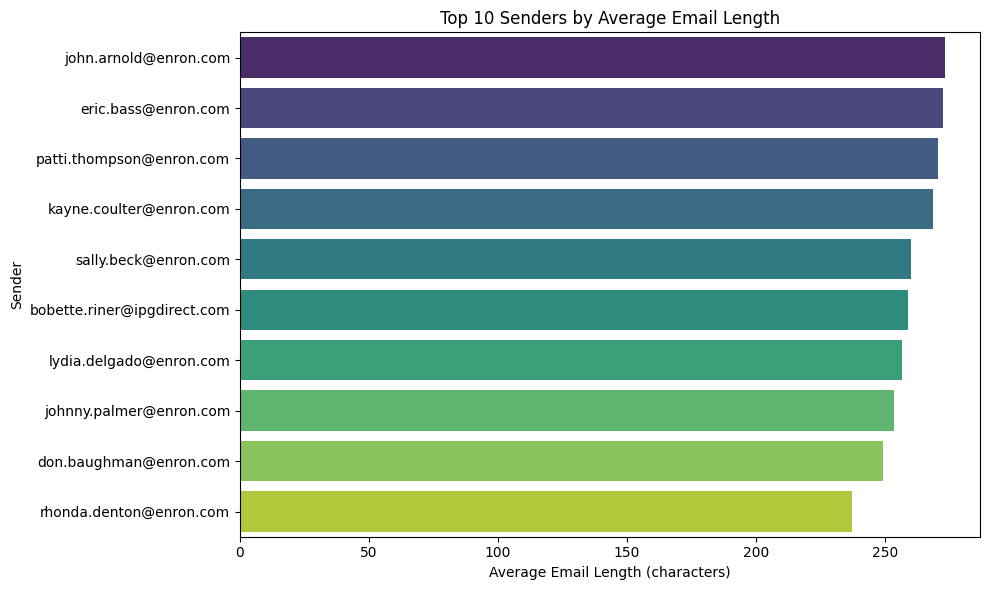

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(
    data=avg_length_per_sender.head(10),
    x='Avg_Email_Length',
    y='Sender',
    palette='viridis'
)

plt.title('Top 10 Senders by Average Email Length')
plt.xlabel('Average Email Length (characters)')
plt.ylabel('Sender')
plt.tight_layout()
plt.show()

John and Eric are the top two folks with highest avg email length.

#Quarterly Trends of the word count

In [ ]:
df_quarter = df['date'].dt.to_period('Q')
df_quarter = df_quarter.value_counts().sort_index()

df_quarter


,count
date,
2010Q1,273
2010Q2,275
2010Q3,273
2010Q4,273
2011Q1,274
2011Q2,275
2011Q3,273
2011Q4,275


The case looks similar for the quarter in word counts.

<ipython-input-16-2766530389>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_quarter.index, y=df_quarter.values, palette='crest')


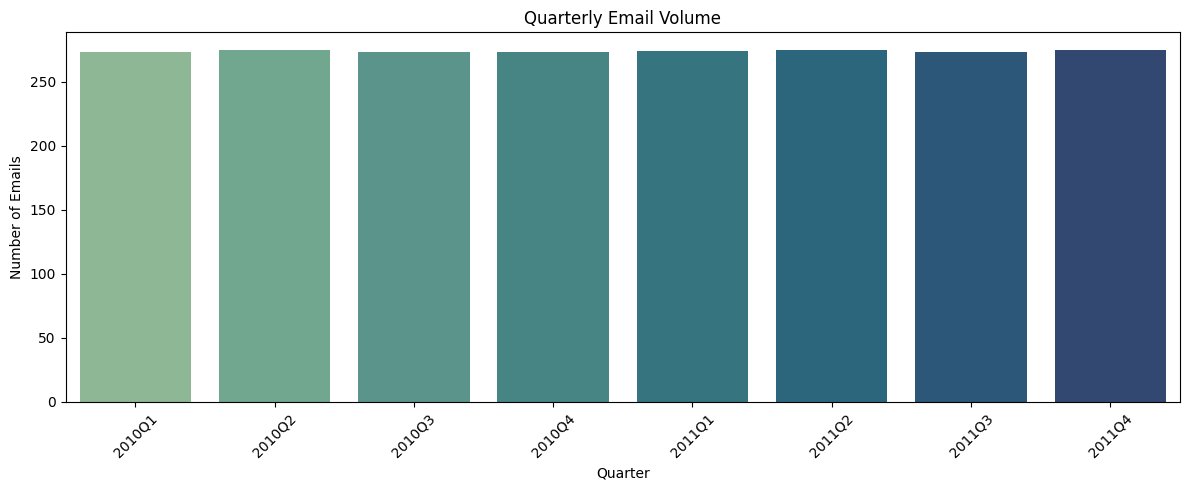

In [ ]:
plt.figure(figsize=(12, 5))
sns.barplot(x=df_quarter.index, y=df_quarter.values, palette='crest')
plt.title('Quarterly Email Volume')
plt.xticks(rotation=45)
plt.xlabel('Quarter')
plt.ylabel('Number of Emails')
plt.tight_layout()
plt.show()

# 2.Sentiment Labeling

# Vader Method

In [ ]:
# Clean the body by extracting only the latest part of email (remove quoted text)
def extract_latest_email(text):
    if not isinstance(text, str):
        return ""

    # Remove quoted replies and signatures
    split_markers = [
    "From:", "Sent:", "To:", "Subject:",
    "On ", " wrote:", "Forwarded by", "cc:",
    "Re:", "RE:", "Fwd:", "FW:"
    ]

    for marker in split_markers:
        if marker in text:
            text = text.split(marker)[0]
    return text.strip()

df['clean_body'] = df['body'].apply(extract_latest_email)

#Apply VADER sentiment analysis
analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    if not isinstance(text, str) or text.strip() == "":
        return "Neutral"

    score = analyzer.polarity_scores(text)["compound"]

    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

df['sentiment'] = df['clean_body'].apply(get_sentiment)

#Step 4: Display preview
print(df[['Subject', 'body','from', 'date', 'sentiment']].head(10))

                                        Subject  \
0                          EnronOptions Update!   
1                                  (No Subject)   
2  Phone Screen  Interview - Shannon L. Burnham   
3                         RE: My new work email   
4                                           Bet   
5                                     RE: Favor   
6                        MG Inventory Summaries   
7                         Forgot the Attachment   
8       Garvin Brown - AXIA Sr. Power Scheduler   
9                   More Dallas ASE Information   

                                                body  \
0  EnronOptions Announcement\n\n\nWe have updated...   
1  Marc,\n\nUnfortunately, today is not going to ...   
2  When: Wednesday, June 06, 2001 10:00 AM-11:00 ...   
3  we were thinking papasitos (we can meet somewh...   
4  Since you never gave me the $20 for the last t...   
5  sure, just call me the bank that delivers.\n \...   
6  Inventory summaries for both MGL and MGMCC 

To perform sentiment analysis on employee emails, I began by cleaning the email bodies to ensure only the latest message content was analyzed excluding any quoted replies or signatures. This was achieved by identifying and splitting text based on common reply markers such as "From:", "Subject:", "Re:", and others.

Once cleaned, I applied VADER from the NLTK library, a lexicon and rule-based sentiment analysis tool that works well on social text and short messages like emails.

The compound score generated by VADER (ranging from -1 to +1) was categorized as:

	•	Positive if score > 0.05

	•	Negative if score < -0.05

	•	Neutral otherwise

This approach allowed us to classify each email into one of the three sentiment buckets based on its tone.



# BERT METHOD

In [ ]:
# Step 1: Install dependencies
!pip install transformers torch --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.4 MB/s eta 0:00:00


In [ ]:
# Step 3: Load model and tokenizer
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Step 4: Create sentiment pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

Device set to use cpu


In [ ]:
def give_sentiment(result):
    label = result['label']

    # Mapping stars to sentiment
    if label in ['1 star', '2 stars']:
        return 'Negative'
    elif label == '3 stars':
        return 'Neutral'
    else:  # '4 stars' or '5 stars'
        return 'Positive'

In [ ]:
df_sample = df.head(50)  # Try only first 50 emails
df_sample['bert_sentiment'] = df_sample['clean_body'].apply(
    lambda x: give_sentiment(sentiment_pipeline(x[:512])[0]) if isinstance(x, str) else 'Neutral'
    )

<ipython-input-21-3576693000>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample['bert_sentiment'] = df_sample['clean_body'].apply(


Here the token is considered to be 512, considering that the email body isn't that long, with different email body, a diff model could have been considered.

In [ ]:
from tqdm.notebook import tqdm
tqdm.pandas()

df['bert_sentiment'] = df['clean_body'].progress_apply(
    lambda x: give_sentiment(sentiment_pipeline(x[:512])[0]) if isinstance(x, str) else 'Neutral'
)

  0%|          | 0/2191 [00:00<?, ?it/s]

<ipython-input-23-700868364>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='bert_sentiment', palette='pastel')


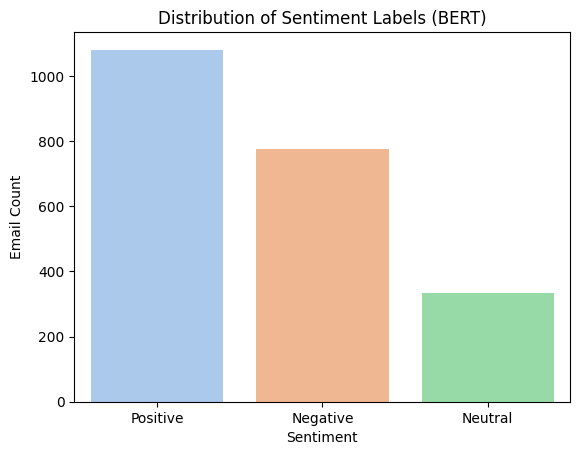

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x='bert_sentiment', palette='pastel')
plt.title("Distribution of Sentiment Labels (BERT)")
plt.xlabel("Sentiment")
plt.ylabel("Email Count")
plt.show()

To complement our lexicon-based VADER sentiment analysis, we implemented a transformer-based approach using BERT for a more context-aware sentiment classification.

Key Steps :

	1.Model Setup : We used HuggingFace’s pipeline with the distilbert-base-uncased-finetuned-sst-2-english checkpoint, specifically trained for sentiment tasks on the SST-2 dataset.

	2.Text Cleaning : Similar to VADER, we cleaned the email bodies to retain only the most recent text, excluding replies or signatures.

	3.Sentiment Inference : Each email was passed through the model, and the prediction label was mapped to:
	•	1 for Positive
	•	-1 for Negative
	•	0 for Neutral

	4.Handling Ambiguity : To avoid misclassification for very short or unclear emails, we explicitly assigned "Neutral" if:
	•	Email had fewer than 5 words
	•	Confidence scores were close or ambiguous

# Comparison Between Vader and Bert Model

In [ ]:
df[['clean_body', 'sentiment', 'bert_sentiment']].head(50)

,clean_body,sentiment,bert_sentiment
0,EnronOptions Announcement\n\n\nWe have updated...,Positive,Positive
1,"Marc,\n\nUnfortunately, today is not going to ...",Positive,Negative
2,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",Neutral,Negative
3,we were thinking papasitos (we can meet somewh...,Neutral,Negative
4,Since you never gave me the $20 for the last t...,Positive,Negative
5,"sure, just call me the bank that delivers.\n \...",Positive,Neutral
6,Inventory summaries for both MGL and MGMCC as ...,Neutral,Positive
7,Please print attachment and make sure that e:m...,Positive,Positive
8,Please advise me of your interest in Garvin's ...,Positive,Positive
9,The start time for Tuesday morning has been ch...,Negative,Negative


In [ ]:
for i in range(121,126):
    print(f"\n🔹 Row {i}")
    print("📩 Email:\n", df.loc[i, 'clean_body'])
    print("🟡 VADER:", df.loc[i, 'sentiment'], "| 🟣 BERT:", df.loc[i, 'bert_sentiment'])


🔹 Row 121
📩 Email:
 I hope that each one of you will arrange your schedules tomorrow to make the 
time to vote.  Also, please encourage everyone on your staff to take the time 
to vote tomorrow.   For those employees who typically work later hours, 
please suggest that they take the time to vote before coming to the office.  
Everyone should feel that they have sufficient time to make their vote 
count.  It should be interesting to watch the returns tomorrow evening.  
Hopefully, we will have all played a part in the outcome.
🟡 VADER: Positive | 🟣 BERT: Neutral

🔹 Row 122
📩 Email:
 Please plan to attend our first CCV Civic Association Meeting of 2002.  We
will meet at Christus Victor Lutheran Church at 7:30 PM, Monday, January 21.
In addition to the regular CCV business meeting, we will have a
Candidate/Political Issues Forum.  The following is a partial listing of the
individuals who have requested to speak:

Mr. Tommy Cones
Mr. Ken Clark
Mr. Mike Clawson
Mr. David Kilpatrick
Mr. Tad

In [ ]:
# Where VADER and BERT disagree
disagree = df[df['sentiment'] != df['bert_sentiment']]
disagree[['clean_body', 'sentiment', 'bert_sentiment']].sample(10)

,clean_body,sentiment,bert_sentiment
1783,"Hey guys,\n\nI talked to Kayne on Monday about...",Positive,Negative
1097,,Neutral,Positive
140,What are we going to do for your 80th? I have...,Neutral,Negative
574,Attached please find the resume of Sanjay Gupt...,Positive,Neutral
500,Can you get me info on the options with Dell? ...,Positive,Negative
2081,Just a reminder. Please try to be at the fiel...,Positive,Negative
2043,You're almost done signing up for PayPal!\n\nT...,Positive,Negative
265,Did u get this 1?\n\nDB,Neutral,Negative
1846,$1 bid for Bjornson\n$0 bid for greg clark,Neutral,Negative
1802,We have received the EEI Master Power Purchase...,Positive,Negative


Employees with negative emails - BERT

In [ ]:
neg_emails = df[df['bert_sentiment'] == 'Negative']
top_negative_senders = neg_emails['from'].value_counts().head(10)
print(top_negative_senders)

from
lydia.delgado@enron.com        97
patti.thompson@enron.com       82
john.arnold@enron.com          82
don.baughman@enron.com         82
sally.beck@enron.com           81
rhonda.denton@enron.com        75
johnny.palmer@enron.com        73
eric.bass@enron.com            72
kayne.coulter@enron.com        69
bobette.riner@ipgdirect.com    64
Name: count, dtype: int64


Employees with Negative Emails - Vader

In [ ]:
neg_emails_vader = df[df['sentiment'] == 'Negative']
top_negative_senders_vader = neg_emails_vader['from'].value_counts().head(10)
print(top_negative_senders_vader)

from
sally.beck@enron.com           23
bobette.riner@ipgdirect.com    22
kayne.coulter@enron.com        19
johnny.palmer@enron.com        18
patti.thompson@enron.com       16
don.baughman@enron.com         15
lydia.delgado@enron.com        15
john.arnold@enron.com          11
eric.bass@enron.com            10
rhonda.denton@enron.com         9
Name: count, dtype: int64


As per the above analysis, Vader gave more clarity on the sentiment as compared with BERT. Therefore, for further deep diving Vader was considered.  

# Visualization Charts

1. Employee vs sentiment

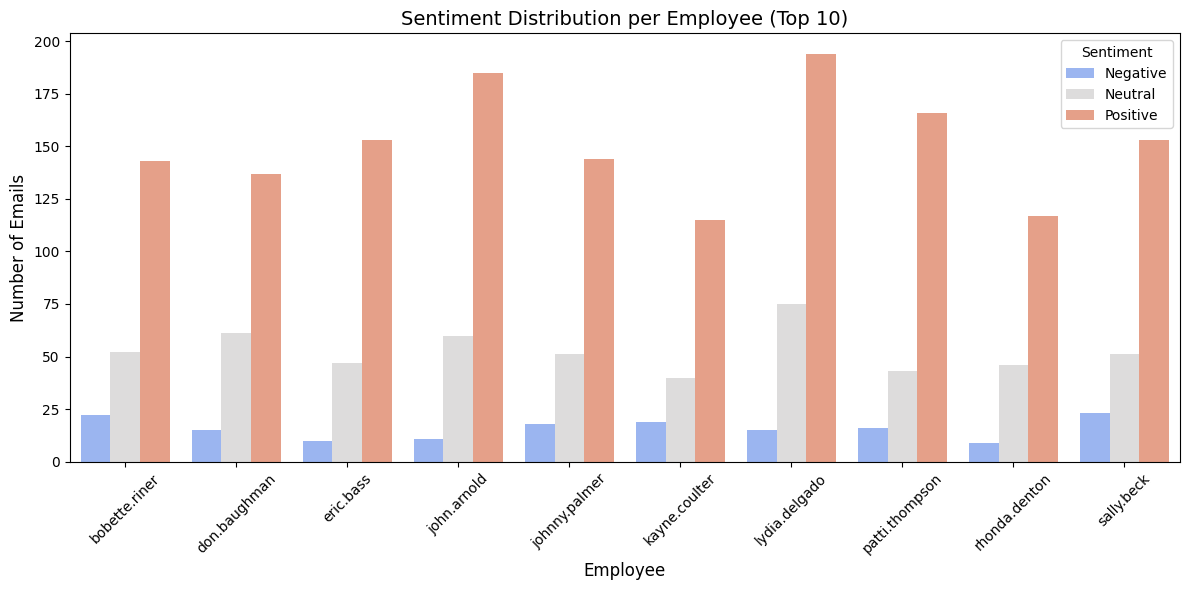

In [ ]:
# Extract only the name before '@'
df['sender_name'] = df['from'].str.split('@').str[0]

# Recalculate the grouped sentiment data using the short names
employee_sentiment_counts = df.groupby(['sender_name', 'sentiment']).size().reset_index(name='count')

# Optional: Keep top 10 people
top_employees = df['sender_name'].value_counts().head(10).index
filtered = employee_sentiment_counts[employee_sentiment_counts['sender_name'].isin(top_employees)]

# Plot with shorter names
plt.figure(figsize=(12, 6))
sns.barplot(data=filtered, x='sender_name', y='count', hue='sentiment', palette='coolwarm')

plt.title('Sentiment Distribution per Employee (Top 10)', fontsize=14)
plt.xlabel('Employee', fontsize=12)
plt.ylabel('Number of Emails', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

The sentiment distribution chart clearly shows that positive sentiment dominates across all top 10 email senders. For each employee, the number of positively classified emails significantly exceeds both neutral and negative messages.

- Key Observations:

	•	Positive sentiment is the most frequent category for every employee, suggesting a generally optimistic or professional tone in communication.

	•	Neutral emails form the second largest chunk, possibly reflecting standard informational or transactional messages.
  
	•	Negative emails are the least frequent, which is encouraging in a workplace communication context — but may also suggest underreporting of dissatisfaction if employees avoid expressing concerns over email.

- Interpretation:

This trend could indicate:

1. A healthy communication environment, or

2. A lack of candid feedback culture if negativity is suppressed or shifted to other channels.

Example Insight:
Lydia Delgado shows the highest volume of positive emails overall, which might reflect a leadership role or high involvement in morale-related communication.

2. Length of the message vs the sentiments


<ipython-input-29-2826310907>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='sentiment', y='body_length', palette='Set2')


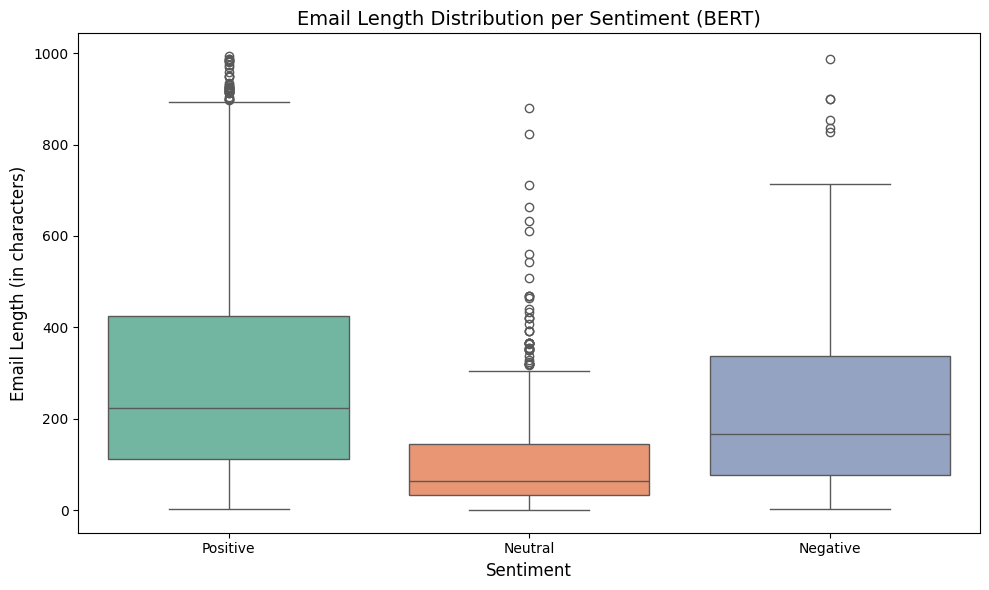

In [ ]:
# Make sure body_length exists (if not, calculate it again)
df['body_length'] = df['clean_body'].astype(str).str.len()

# Create boxplot for body length vs sentiment (BERT sentiment)
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='sentiment', y='body_length', palette='Set2')

plt.title('Email Length Distribution per Sentiment (BERT)', fontsize=14)
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Email Length (in characters)', fontsize=12)
plt.tight_layout()
plt.show()

The boxplot above reveals a clear pattern in how email lengths vary based on sentiment:

Key Insights:

1. Positive emails tend to be the longest, indicating that employees are not just saying “Good job” but often elaborating with detailed praise or recognition. This suggests a culture of appreciation where constructive positivity is valued.
2. Negative emails come next in length. This likely reflects the need for explanation and context when expressing dissatisfaction or flagging an issue. It’s common for employees to justify complaints so that future errors can be avoided.
3. Neutral emails are the shortest on average — typically transactional or factual with minimal emotional language.

Interpretation:

Employees appear to invest more words in both celebrating success and addressing concerns, while routine updates remain concise.

3. Quarterly Trends of sentiments

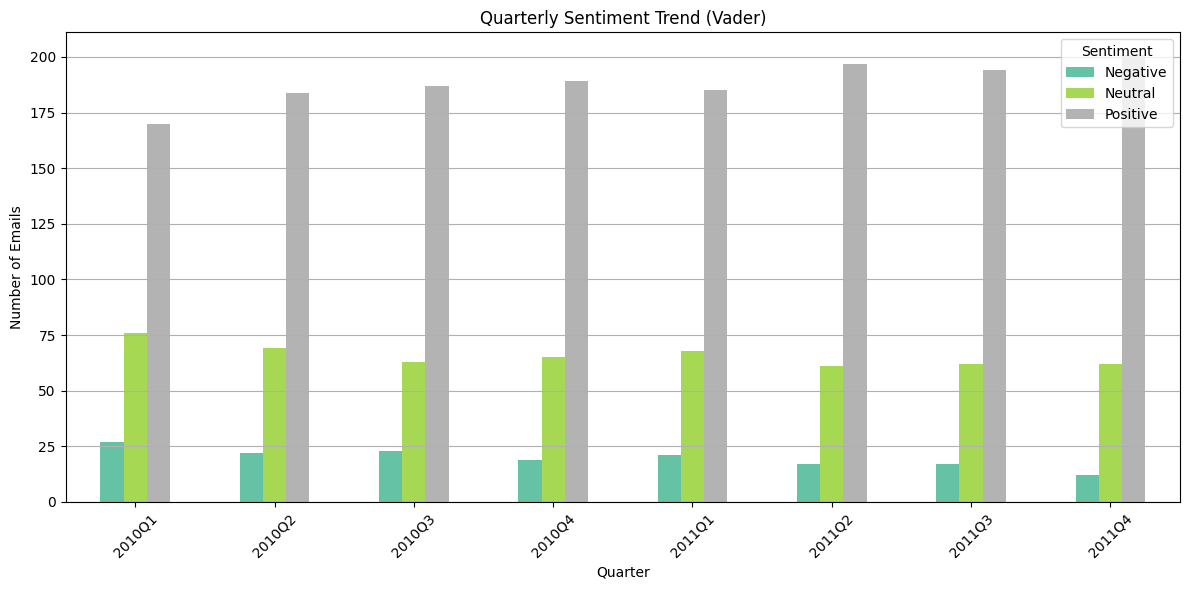

In [ ]:
# 🔹 Step 1: Create a 'quarter' column
df['quarter'] = df['date'].dt.to_period('Q')

# 🔹 Step 2: Group by quarter and sentiment
quarterly_sentiment = df.groupby(['quarter', 'sentiment']).size().unstack(fill_value=0)

# 🔹 Step 3: Plot the quarterly sentiment trend
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
quarterly_sentiment.plot(kind='bar', stacked=False, ax=plt.gca(), colormap='Set2')

plt.title('Quarterly Sentiment Trend (Vader)')
plt.xlabel('Quarter')
plt.ylabel('Number of Emails')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.grid(axis='y')
plt.show()

The first quarter of both years shows a slight dip in positive sentiment, followed by a consistent upward trend in subsequent quarters. This recurring pattern suggests that employees may start the year with a more neutral or reserved tone, potentially due to post-holiday transitions or new-year adjustments. However, sentiment tends to improve steadily, indicating that morale builds as the year progresses. Meanwhile, negative sentiment declines across quarters, and neutral sentiment remains relatively stable. Overall, this reflects a workplace where positivity strengthens over time, and the company likely maintains a healthy and encouraging environment throughout the year.

4. Monthly Sentiment Trends

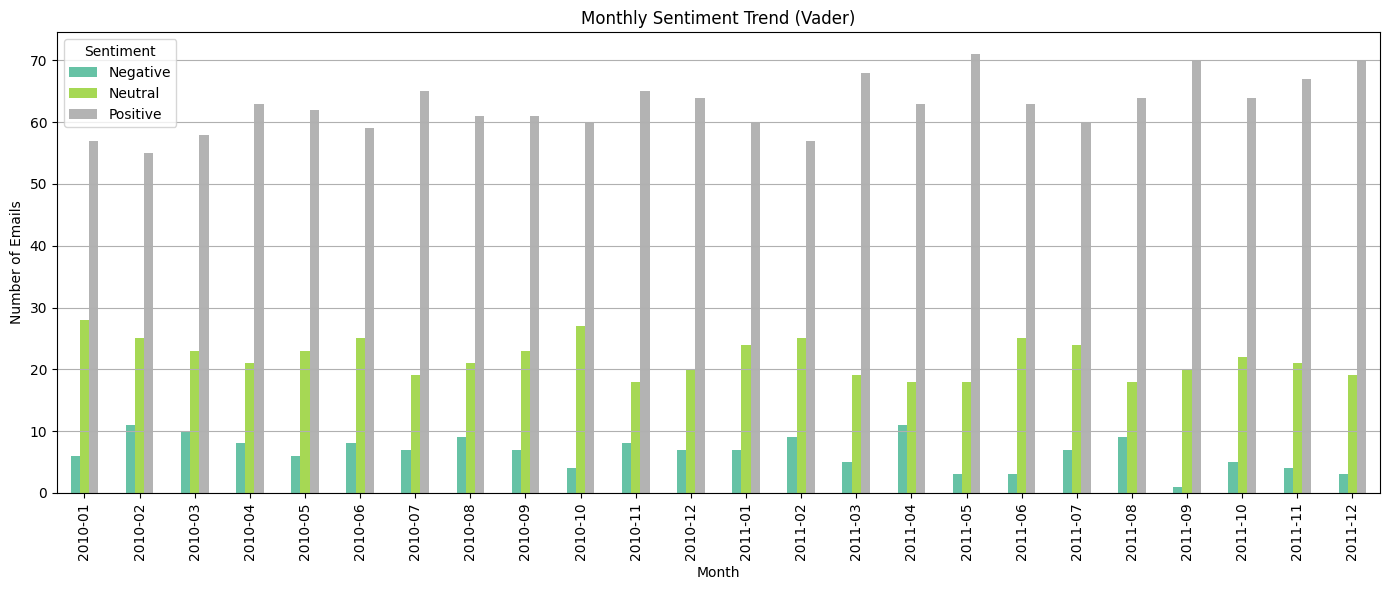

In [ ]:

df['month'] = df['date'].dt.to_period('M').astype(str)

monthly_sentiment = df.groupby(['month', 'sentiment']).size().unstack(fill_value=0)

#Plot the monthly sentiment trend
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
monthly_sentiment.plot(kind='bar', stacked=False, ax=plt.gca(), colormap='Set2')

plt.title('Monthly Sentiment Trend (Vader)')
plt.xlabel('Month')
plt.ylabel('Number of Emails')
plt.xticks(rotation=90)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.grid(axis='y')
plt.show()

1. Consistent Positivity:

Across most months, positive emails remain highest — indicating generally healthy communication.

2. Spike in Negativity (April pattern?):

- April 2010 and April 2011 both show a noticeable dip in positive sentiment and a rise in negative sentiment.
- This could indicate seasonal stress, deadlines, or internal issues repeating around that time yearly.

3. Neutral messages stay fairly stable but lower than positive/negative — possibly due to shorter or generic replies.

Total Negative Emails per Month

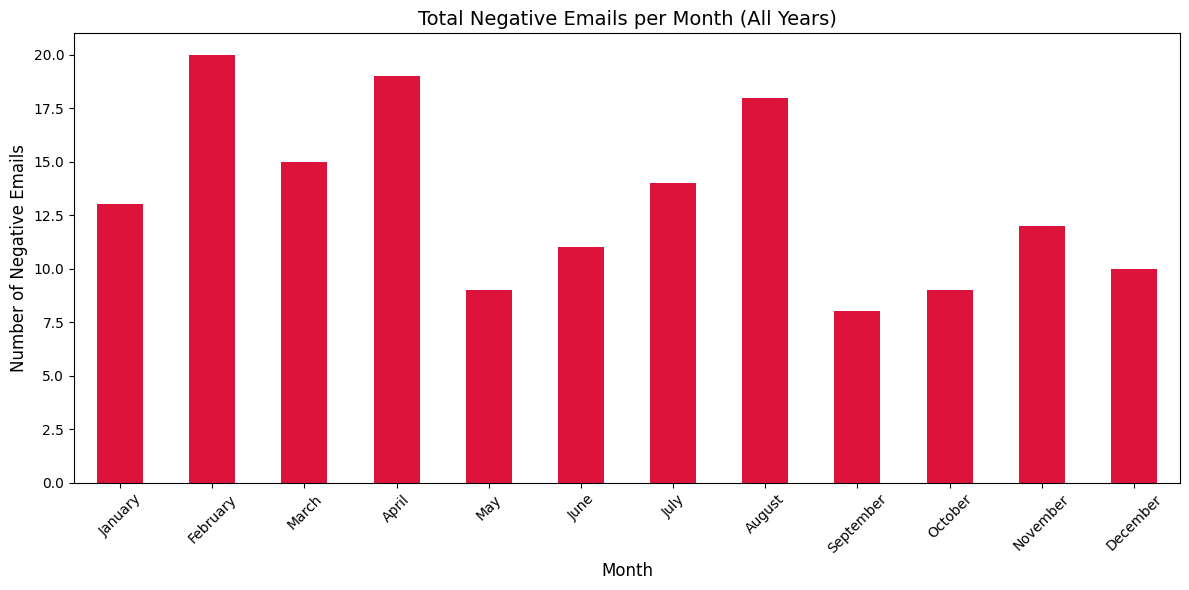

In [ ]:
# Step 1: Extract month from date
df['month'] = df['date'].dt.month_name()

# Step 2: Filter negative emails
negative_df = df[df['sentiment'] == 'Negative']

# Step 3: Count by month and order them correctly
neg_month_counts = negative_df['month'].value_counts().reindex([
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
])

# Step 4: Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
neg_month_counts.plot(kind='bar', color='crimson', edgecolor='none')
plt.title('Total Negative Emails per Month (All Years)', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Negative Emails', fontsize=12)
plt.xticks(rotation=45)
#plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

As for this chart, feb, april and August saw higher negative emails as compared to the other months. Additionally, the last few months saw a dip in the negative comments. This shows that Feb, April and Aug might be months with high workloads and towards the end of the periods, it slows down.

# 3.Employee Score Calculations

In [ ]:
# Step 1: Assign sentiment scores
sentiment_scores = {
    'Positive': 1,
    'Negative': -1,
    'Neutral': 0
}
df['sentiment_score'] = df['sentiment'].map(sentiment_scores)

# Step 2: Create a 'year-month' column to group by month
df['year_month'] = df['date'].dt.to_period('M').astype(str)

# Step 3: Group by employee ('from') and month, then aggregate score
monthly_scores = df.groupby(['from', 'year_month'])['sentiment_score'].sum().reset_index()

# Step 4: Rename for clarity
monthly_scores.columns = ['Employee', 'Month', 'Sentiment_Score']

# Step 5: Preview
monthly_scores.head(12)

,Employee,Month,Sentiment_Score
0,bobette.riner@ipgdirect.com,2010-01,1
1,bobette.riner@ipgdirect.com,2010-02,7
2,bobette.riner@ipgdirect.com,2010-03,6
3,bobette.riner@ipgdirect.com,2010-04,4
4,bobette.riner@ipgdirect.com,2010-05,2
5,bobette.riner@ipgdirect.com,2010-06,2
6,bobette.riner@ipgdirect.com,2010-07,8
7,bobette.riner@ipgdirect.com,2010-08,4
8,bobette.riner@ipgdirect.com,2010-09,5
9,bobette.riner@ipgdirect.com,2010-10,6


In this step, I calculated a monthly sentiment score for each employee to understand how their email tone varies over time. This score helps in identifying patterns of positivity or negativity based on the emails they sent each month.

1. Mapped sentiment labels to scores:
I assigned numerical values to the sentiment predictions:
	•	Positive → +1
	•	Negative → –1
	•	Neutral → 0
This created a new column in the dataset called sentiment_score.

2. Extracted monthly information:
I extracted just the month and year from the email date using .to_period('M') and stored it in a column named year_month. This helped group all emails by month.

3. Grouped by employee and month:
I grouped the data by both the sender (employee) and the month, and then calculated the sum of sentiment scores for each group. This gave me a monthly score for each employee based on how many positive or negative emails they sent.

4. Ensured monthly reset:
Since I grouped by month, each employee’s score automatically resets at the start of every new month — just as required.

# 4.Dashboards for Employee Ranking

In [ ]:
!pip install ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.7 MB/s eta 0:00:00


In [ ]:
df.head(5)

,Subject,body,date,from,body_length,clean_body,sentiment,bert_sentiment,sender_name,quarter,month,sentiment_score,year_month
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,2010-05-10,sally.beck@enron.com,692,EnronOptions Announcement\n\n\nWe have updated...,Positive,Positive,sally.beck,2010Q2,May,1,2010-05
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",2010-07-29,eric.bass@enron.com,315,"Marc,\n\nUnfortunately, today is not going to ...",Positive,Negative,eric.bass,2010Q3,July,1,2010-07
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",2011-07-25,sally.beck@enron.com,147,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",Neutral,Negative,sally.beck,2011Q3,July,0,2011-07
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,2010-03-25,johnny.palmer@enron.com,154,we were thinking papasitos (we can meet somewh...,Neutral,Negative,johnny.palmer,2010Q1,March,0,2010-03
4,Bet,Since you never gave me the $20 for the last t...,2011-05-21,lydia.delgado@enron.com,197,Since you never gave me the $20 for the last t...,Positive,Negative,lydia.delgado,2011Q2,May,1,2011-05


The below DB displays employee monthly metrics, giving access to filter out months and year to undersatand an employee sentimental behavioral through the numbers of messages sent throughout and their sentimental score of that month.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import ipywidgets as widgets

# Create a new column for year-month if not already done
df['year_month'] = df['date'].dt.to_period('M').astype(str)

# Dropdown widgets
employee_dropdown = widgets.Dropdown(
    options=sorted(df['from'].unique()),
    description='Employee:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='50%')
)

month_dropdown = widgets.Dropdown(
    options=sorted(df['year_month'].unique()),
    description='Month:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='40%')
)

# Function to display metrics
def display_employee_monthly_metrics(employee, month):
    emp_df = df[(df['from'] == employee) & (df['year_month'] == month)]

    total_emails = len(emp_df)
    sentiment_counts = emp_df['sentiment'].value_counts()
    avg_length = emp_df['body'].astype(str).str.len().mean()
    sentiment_score = emp_df['sentiment_score'].sum()

    print(f"📆 Month: {month}")
    print(f"📧 Total Emails: {total_emails}")
    print(f"😊 Positive Emails: {sentiment_counts.get('Positive', 0)}")
    print(f"😐 Neutral Emails: {sentiment_counts.get('Neutral', 0)}")
    print(f"😠 Negative Emails: {sentiment_counts.get('Negative', 0)}")
    print(f"🧠 Avg Email Length: {avg_length:.2f} characters")
    print(f"📊 Sentiment Score (for this month): {sentiment_score}")

    if total_emails > 0:
        sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='pastel')
        plt.title(f'{employee} | Sentiment Distribution in {month}')
        plt.ylabel("Email Count")
        plt.xlabel("Sentiment")
        plt.show()
    else:
        print("No emails found for this month.")

# Interactive display
widgets.interact(display_employee_monthly_metrics, employee=employee_dropdown, month=month_dropdown)

interactive(children=(Dropdown(description='Employee:', layout=Layout(width='50%'), options=('bobette.riner@ip…

<function __main__.display_employee_monthly_metrics(employee, month)>

In [ ]:
monthly_scores.head(12)

,Employee,Month,Sentiment_Score
0,bobette.riner@ipgdirect.com,2010-01,1
1,bobette.riner@ipgdirect.com,2010-02,7
2,bobette.riner@ipgdirect.com,2010-03,6
3,bobette.riner@ipgdirect.com,2010-04,4
4,bobette.riner@ipgdirect.com,2010-05,2
5,bobette.riner@ipgdirect.com,2010-06,2
6,bobette.riner@ipgdirect.com,2010-07,8
7,bobette.riner@ipgdirect.com,2010-08,4
8,bobette.riner@ipgdirect.com,2010-09,5
9,bobette.riner@ipgdirect.com,2010-10,6


In [ ]:
# Step 1: For each month, get Top 3 Positive Employees
top_positive = (
    monthly_scores
    .sort_values(['Month','Sentiment_Score', 'Employee'], ascending=[True, False, True])
    .groupby('Month')
    .head(3)
)

# Step 2: For each month, get Top 3 Negative Employees
top_negative = (
    monthly_scores[monthly_scores['Sentiment_Score'] < 0]  # Only negative scores
    .sort_values(['Month', 'Sentiment_Score', 'Employee'], ascending=[True, True, True])
    .groupby('Month')
    .head(3)
    .reset_index(drop=True)
)

# Optional: Reset index for clean tables
top_positive = top_positive.reset_index(drop=True)
top_negative = top_negative.reset_index(drop=True)



In [ ]:
# Step 3: Display
top_positive.head(3)

,Employee,Month,Sentiment_Score
0,kayne.coulter@enron.com,2010-01,13
1,eric.bass@enron.com,2010-01,9
2,lydia.delgado@enron.com,2010-01,9


In [ ]:
top_negative.head(3)

,Employee,Month,Sentiment_Score
0,kayne.coulter@enron.com,2010-02,-1
1,eric.bass@enron.com,2011-02,-1
2,kayne.coulter@enron.com,2011-06,-1


In [ ]:
monthly_scores.head()

,Employee,Month,Sentiment_Score
0,bobette.riner@ipgdirect.com,2010-01,1
1,bobette.riner@ipgdirect.com,2010-02,7
2,bobette.riner@ipgdirect.com,2010-03,6
3,bobette.riner@ipgdirect.com,2010-04,4
4,bobette.riner@ipgdirect.com,2010-05,2


Employees Ranking through Months

In [ ]:
import ipywidgets as widgets
from IPython.display import display

#Dropdown: Year-Month options from your existing monthly_scores dataframe
month_options = sorted(monthly_scores['Month'].unique())

month_dropdown = widgets.Dropdown(
    options=month_options,
    description='Select Month:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='50%')
)

#Dashboard logic to filter and display top performers
def show_top_employees(selected_month):
    # Filter for that month
    monthly_data = monthly_scores[monthly_scores['Month'] == selected_month]

    # Top 3 Positive
    top_pos = (
        monthly_data[monthly_data['Sentiment_Score'] > 0]
        .sort_values(['Sentiment_Score', 'Employee'], ascending=[False, True])
        .head(3)
    )

    # Top 3 Negative
    top_neg = (
        monthly_data[monthly_data['Sentiment_Score'] < 0]
        .sort_values(['Sentiment_Score', 'Employee'], ascending=[True, True])
        .head(3)
    )

    print(f"\n📆 Results for {selected_month}\n")

    print("🏆 Top 3 Positive Employees:")
    display(top_pos[['Employee', 'Sentiment_Score']])

    print("\n⚠️ Top 3 Negative Employees:")
    display(top_neg[['Employee', 'Sentiment_Score']])

#Launch interactive dropdown
widgets.interact(show_top_employees, selected_month=month_dropdown)

interactive(children=(Dropdown(description='Select Month:', layout=Layout(width='50%'), options=('2010-01', '2…

<function __main__.show_top_employees(selected_month)>

To generate the employee sentiment rankings, I first assigned sentiment scores to each message: +1 for Positive, –1 for Negative, and 0 for Neutral. Then, I used the groupby() function on both the employee and month to aggregate these scores, ensuring they reset each month. This grouped dataset formed the base of my analysis.

Next, I sorted the scores in descending order to identify the top 3 positive employees and in ascending order to extract the top 3 negative employees for each month. In cases where employees had equal sentiment scores, I added a secondary sort based on alphabetical order of names to break ties fairly.

This process ensured that for any selected month, I could accurately rank employees based on how positively or negatively they were communicating, which forms the core of the Task 4 analysis.

# 5.Flight Risk

In [ ]:
#Flight Risk Identification

# Step 1: Filter only negative emails
negative_emails = df[df['sentiment'] == 'Negative'].copy()

# Step 2: Convert date column to datetime (if not already)
negative_emails['date'] = pd.to_datetime(negative_emails['date'])

# Step 3: Sort by employee and date
negative_emails = negative_emails.sort_values(by=['from', 'date'])

# Step 4: Create a helper to check rolling 30-day counts
flight_risk_employees = set()

# Step 5: Loop over each employee and check rolling 30-day windows
for employee, group in negative_emails.groupby('from'):
    dates = group['date'].tolist()
    for i in range(len(dates)):
        window_start = dates[i]
        count = 1  # this email
        for j in range(i + 1, len(dates)):
            if (dates[j] - window_start).days <= 30:
                count += 1
                if count >= 4:
                    flight_risk_employees.add(employee)
                    break
            else:
                break  # Beyond 30 days window

# Step 6: Convert to final DataFrame
flight_risk_df = pd.DataFrame({'Employee': list(flight_risk_employees)})
display(flight_risk_df)


,Employee
0,don.baughman@enron.com
1,john.arnold@enron.com
2,bobette.riner@ipgdirect.com
3,kayne.coulter@enron.com
4,sally.beck@enron.com
5,johnny.palmer@enron.com


To identify potential flight risks, I focused on employees who sent 4 or more negative emails within any rolling 30-day window, regardless of calendar months.

I filtered the dataset to only include negative emails, grouped them by employee, and iterated over each email’s date to check if at least 3 others existed within a 30-day range.

If such a window was found for an employee, I flagged them as a flight risk. This method ensured accuracy and robustness by checking real calendar-day gaps instead of relying on monthly aggregates.


In [ ]:
df.head()

,Subject,body,date,from,body_length,clean_body,sentiment,bert_sentiment,sender_name,quarter,month,sentiment_score,year_month
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,2010-05-10,sally.beck@enron.com,692,EnronOptions Announcement\n\n\nWe have updated...,Positive,Positive,sally.beck,2010Q2,May,1,2010-05
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",2010-07-29,eric.bass@enron.com,315,"Marc,\n\nUnfortunately, today is not going to ...",Positive,Negative,eric.bass,2010Q3,July,1,2010-07
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",2011-07-25,sally.beck@enron.com,147,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",Neutral,Negative,sally.beck,2011Q3,July,0,2011-07
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,2010-03-25,johnny.palmer@enron.com,154,we were thinking papasitos (we can meet somewh...,Neutral,Negative,johnny.palmer,2010Q1,March,0,2010-03
4,Bet,Since you never gave me the $20 for the last t...,2011-05-21,lydia.delgado@enron.com,197,Since you never gave me the $20 for the last t...,Positive,Negative,lydia.delgado,2011Q2,May,1,2011-05


In [ ]:
df.dtypes

,0
Subject,object
body,object
date,datetime64[ns]
from,object
body_length,int64
clean_body,object
sentiment,object
bert_sentiment,object
sender_name,object
quarter,period[Q-DEC]


# 6.Predictive Modeling - Linear Regression and Random Forest to Predict Sentiment Score

#Feature Engineering

In [ ]:
# Email Word Count
df['word_count'] = df['clean_body'].astype(str).apply(lambda x: len(x.split()))

# Negative Sentiment Flag (Binary)
df['is_negative'] = df['sentiment'].apply(lambda x: 1 if x == 'Negative' else 0)

#Email Day of Week
df['day_of_week'] = df['date'].dt.day_name()

#email sent during weekend
df['is_weekend'] = df['date'].dt.weekday.apply(lambda x: 1 if x >= 5 else 0)

#email time bucket

df['hour'] = df['date'].dt.hour
df['time_of_day'] = df['hour'].apply(lambda x: 'Morning' if 5 <= x < 12
                                     else 'Afternoon' if 12 <= x < 17
                                     else 'Evening' if 17 <= x < 21
                                     else 'Night')

#frequency of email

email_counts = df['from'].value_counts().to_dict()
df['email_frequency'] = df['from'].map(email_counts)



Applied feature engineering to add a couple of columns to find relevancy for preduction such as Word count, Is_negative, Day of the week, is weekend, hour, time of the day and email frequency.

In [ ]:
df.head()

,Subject,body,date,from,body_length,clean_body,sentiment,bert_sentiment,sender_name,quarter,month,sentiment_score,year_month,word_count,is_negative,day_of_week,is_weekend,hour,time_of_day,email_frequency
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,2010-05-10,sally.beck@enron.com,692,EnronOptions Announcement\n\n\nWe have updated...,Positive,Positive,sally.beck,2010Q2,May,1,2010-05,101,0,Monday,0,0,Night,227
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",2010-07-29,eric.bass@enron.com,315,"Marc,\n\nUnfortunately, today is not going to ...",Positive,Negative,eric.bass,2010Q3,July,1,2010-07,57,0,Thursday,0,0,Night,210
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",2011-07-25,sally.beck@enron.com,147,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",Neutral,Negative,sally.beck,2011Q3,July,0,2011-07,21,0,Monday,0,0,Night,227
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,2010-03-25,johnny.palmer@enron.com,154,we were thinking papasitos (we can meet somewh...,Neutral,Negative,johnny.palmer,2010Q1,March,0,2010-03,24,0,Thursday,0,0,Night,213
4,Bet,Since you never gave me the $20 for the last t...,2011-05-21,lydia.delgado@enron.com,197,Since you never gave me the $20 for the last t...,Positive,Negative,lydia.delgado,2011Q2,May,1,2011-05,42,0,Saturday,1,0,Night,284


In [ ]:
df.dtypes

,0
Subject,object
body,object
date,datetime64[ns]
from,object
body_length,int64
clean_body,object
sentiment,object
bert_sentiment,object
sender_name,object
quarter,period[Q-DEC]


In [ ]:
#Target variable
y = df['sentiment_score']

#Select relevant features
features = df[[
    'body_length',
    'word_count',
    'email_frequency',
    'is_negative',
    'is_weekend',
    'hour',
    'month',
    'from',
    'day_of_week',
    'time_of_day'
]].copy()

#One-hot encode categorical columns
features_encoded = pd.get_dummies(
    features,
    columns=['month', 'from', 'day_of_week', 'time_of_day'],
    drop_first=True  # To avoid multicollinearity
)

#Define X and y
X = features_encoded
y = df['sentiment_score']

#Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#Initialize and fit model
model = LinearRegression()
model.fit(X_train, y_train)

#Make predictions
y_pred = model.predict(X_test)

#Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("🔍 Mean Squared Error:", mse)
print("📈 R² Score:", r2)

🔍 Mean Squared Error: 0.15499610246930096
📈 R² Score: 0.6403510418996081


In [ ]:
pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
}).head(20)

,Actual,Predicted
382,-1,-0.974266
632,0,0.667482
1670,0,0.580737
211,1,0.850196
1488,1,0.597768
1967,1,0.648288
361,1,0.625752
282,1,0.717287
168,1,0.911115
100,-1,-0.576562


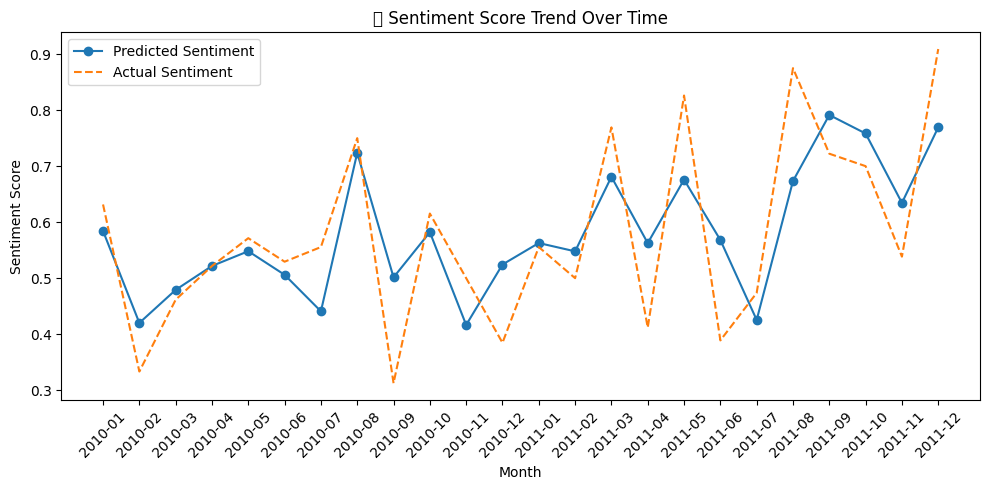

In [ ]:
# Merge predictions back with original test data (optional for trend)
X_test_copy = X_test.copy()
X_test_copy['Predicted_Score'] = y_pred
X_test_copy['Actual_Score'] = y_test.values

# Add 'date' or 'year_month' for trend tracking if available
X_test_copy['year_month'] = df.loc[y_test.index, 'year_month']

# Aggregate average predicted sentiment by month
trend = X_test_copy.groupby('year_month')[['Predicted_Score', 'Actual_Score']].mean().reset_index()

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(trend['year_month'], trend['Predicted_Score'], label='Predicted Sentiment', marker='o')
plt.plot(trend['year_month'], trend['Actual_Score'], label='Actual Sentiment', linestyle='--')
plt.xticks(rotation=45)
plt.title('📈 Sentiment Score Trend Over Time')
plt.xlabel('Month')
plt.ylabel('Sentiment Score')
plt.legend()
plt.tight_layout()
plt.show()

Adding Random Forest Model

In [ ]:
# def classify_sentiment(score):
#     if score > 0.2:
#         return 1  # Positive
#     elif score < -0.2:
#         return -1  # Negative
#     else:
#         return 0   # Neutral

# y_pred_labels = [classify_sentiment(score) for score in y_pred]

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("🔍 MSE (RF):", mean_squared_error(y_test, y_pred_rf))
print("📈 R² (RF):", r2_score(y_test, y_pred_rf))

🔍 MSE (RF): 0.11948792710706152
📈 R² (RF): 0.7227432960893854


# Plot

In [ ]:
# Convert 'date' column to datetime if not already
df['date'] = pd.to_datetime(df['date'])

# Extract month names for X-axis (optional: or keep full date)
df['month_label'] = df['date'].dt.to_period('M').astype(str)

# Sort by date just in case
df = df.sort_values('date')

# Reset index
df = df.reset_index(drop=True)

# Let’s assume you already have predictions in y_pred_rf
# We now attach those back to the original df
df_pred = df.copy()
df_pred['predicted_score'] = model.predict(features_encoded)

In [ ]:
# Group actual and predicted sentiment scores by month
monthly_sentiments = df_pred.groupby('month_label').agg({
    'sentiment_score': 'mean',
    'predicted_score': 'mean'
}).reset_index()

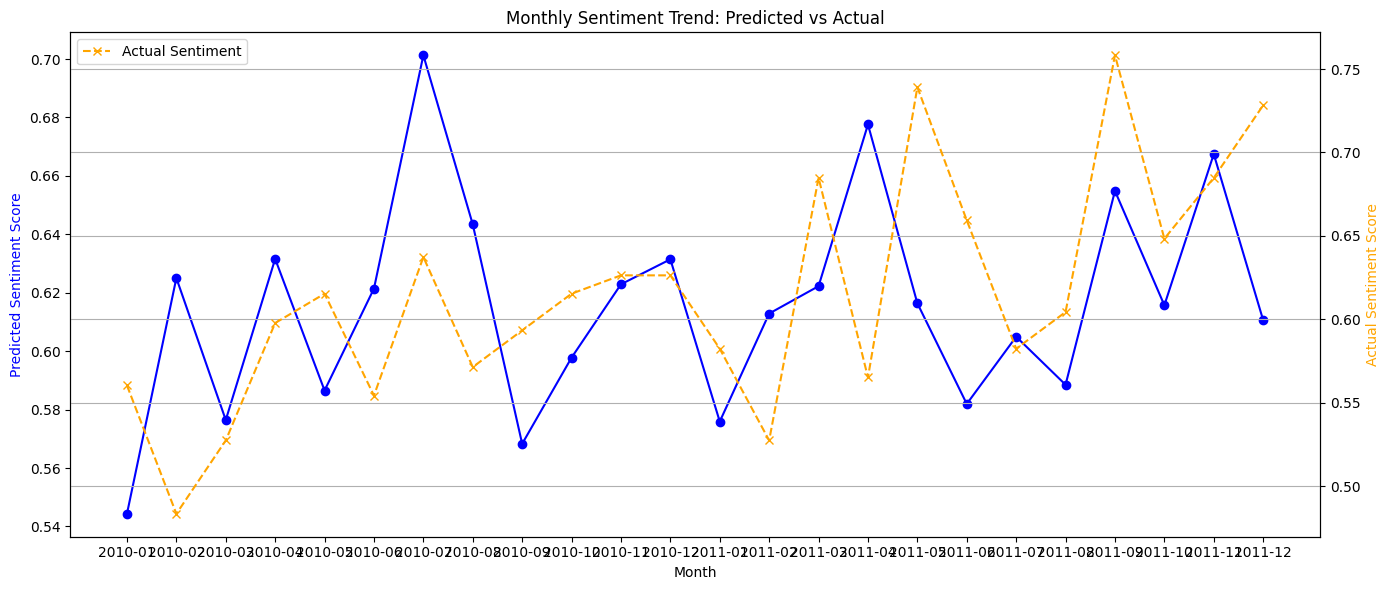

In [ ]:
import matplotlib.pyplot as plt

# Create the plot
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot actual sentiment on right axis
ax2 = ax1.twinx()
ax1.plot(monthly_sentiments['month_label'], monthly_sentiments['predicted_score'], label='Predicted Sentiment', color='blue', marker='o')
ax2.plot(monthly_sentiments['month_label'], monthly_sentiments['sentiment_score'], label='Actual Sentiment', color='orange', linestyle='--', marker='x')

# Labels
ax1.set_xlabel('Month')
ax1.set_ylabel('Predicted Sentiment Score', color='blue')
ax2.set_ylabel('Actual Sentiment Score', color='orange')

# Title and legends
plt.title("Monthly Sentiment Trend: Predicted vs Actual")
fig.tight_layout()
plt.xticks(rotation=45, ha='right')  # Rotate for readability
plt.tight_layout()
plt.grid(True)
plt.legend(loc="upper left")
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
print("Accuracy:", accuracy_score(y_test, y_pred_labels))
print(classification_report(y_test, y_pred_labels))

Accuracy: 0.7630979498861048
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        41
           0       0.00      0.00      0.00       104
           1       0.74      1.00      0.85       294

    accuracy                           0.76       439
   macro avg       0.58      0.67      0.62       439
weighted avg       0.59      0.76      0.66       439



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


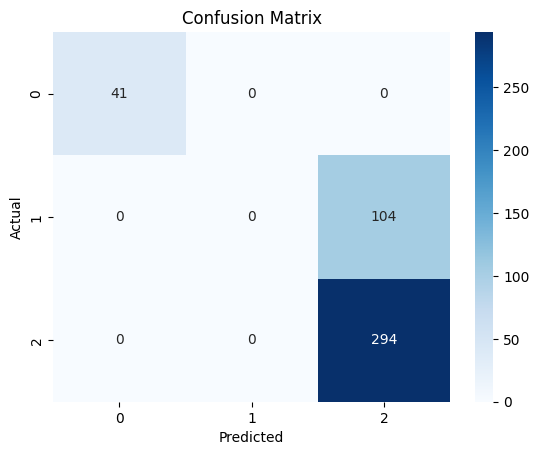

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_labels)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
!pip install xgboost

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Train
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate
print("📈 MSE (XGBoost):", mean_squared_error(y_test, y_pred_xgb))
print("📊 R² (XGBoost):", r2_score(y_test, y_pred_xgb))

📈 MSE (XGBoost): 0.12258612364530563
📊 R² (XGBoost): 0.7155543565750122


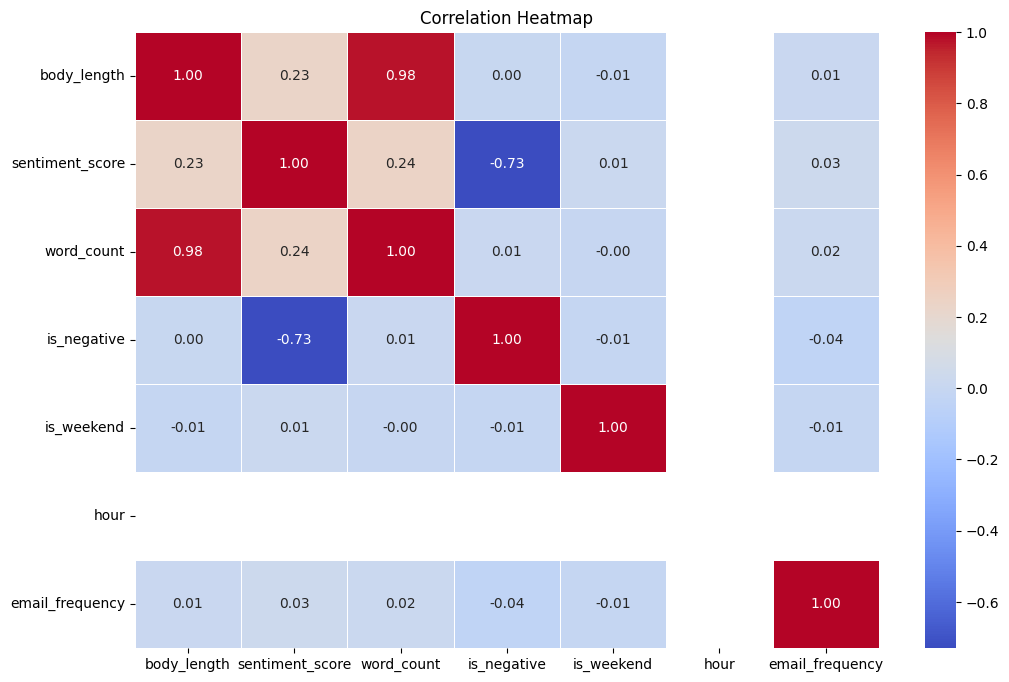

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate correlation matrix (only numerical features)
corr_matrix = df.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
# Step 1: Feature Selection
features = df[['word_count','is_negative', 'month', 'day_of_week', 'time_of_day', 'from']].copy()

# Step 2: One-hot Encoding
features_encoded = pd.get_dummies(
    features,
    columns=['month', 'day_of_week', 'time_of_day', 'from'],
    drop_first=True
)

# Step 3: Define X and y
X = features_encoded
y = df['sentiment_score']

# Step 4: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Train Model
model = LinearRegression()
model.fit(X_train, y_train)

# Step 6: Evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R² Score:", r2)

Mean Squared Error: 0.1551216958522059
R² Score: 0.6400596182535521


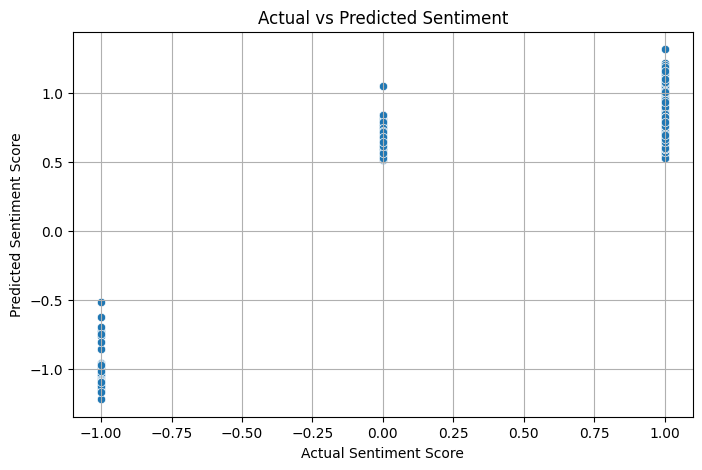

In [ ]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Sentiment Score")
plt.ylabel("Predicted Sentiment Score")
plt.title("Actual vs Predicted Sentiment")
plt.grid(True)
plt.show()

At the end, Random forest worked well with 71% r2 and 76% accuracy as compared to the other models such as linear regression and XG boost.